In [1]:
# IMPORT LIBRARIES #
import pandas as pd
import pygsheets
import numpy as np

In [2]:
# FLAGS #

#Set to 1 to print diagnostic info
debugFlag = 0
#Set to 1 to pull info from RawNames sheet, join GPS, update, and export
updateGPSFlag = 0

In [3]:
# IMPORT DATA #

gc = pygsheets.authorize(service_file='file.json')
sh = gc.open('DashData')

if debugFlag:
    for x in sh:
        print(x)

for x in sh:
    title = x.title
    if(title=="DeliveriesOld"):
        import_sheets_OldDelDF = x.get_as_df()
    elif(title=="Deliveries"):
        import_sheets_DelDF = x.get_as_df()
    elif(title=="Days"):
        import_sheets_DaysDF = x.get_as_df()
    elif(title=="Weeks"):
        import_sheets_WeeksDF = x.get_as_df()
    elif(title=="RawNames"):
        import_sheets_RawNamesDF = x.get_as_df()
    elif(title=="GPS"):
        #for import
        import_sheets_GPSDF = x.get_as_df()
        #for export
        if updateGPSFlag:
            import_wks_gps = x
    else:
        print("Worksheet not stored: ", x)

Worksheet not stored:  <Worksheet 'Import' index:6>
Worksheet not stored:  <Worksheet 'Lifetime Deliveries' index:7>
Worksheet not stored:  <Worksheet 'Days Old' index:8>
Worksheet not stored:  <Worksheet 'Weeks Old' index:9>


In [4]:
# Allows for disjoint cells, one for import, one for reset to import value (for ease of testing)

#DF from sheets
sheets_OldDelDF   = import_sheets_OldDelDF.copy()
sheets_DelDF      = import_sheets_DelDF.copy()
sheets_DaysDF     = import_sheets_DaysDF.copy()
sheets_WeeksDF    = import_sheets_WeeksDF.copy()
sheets_RawNamesDF = import_sheets_RawNamesDF.copy()
sheets_GPSDF      = import_sheets_GPSDF.copy()

In [5]:
# FUNCTIONS #

def processStacks(df):
    df["Stack Encoding"] = 0 
    for index, row in df.iterrows():
        if type(row["Stacked"]) == int:
            df.at[index, "Stack Encoding"] = 2
            df.at[index, "Distance"] /= 2
            df.at[index, "Duration"] /= 2
        else:
            if (row["Stacked"] == ""):
                df.at[index, "Stack Encoding"] = 1
            elif (row["Stacked"] == "PENTA"):
                df.at[index, "Stack Encoding"] = 5
                df.at[index, "Distance"] /= 5
                df.at[index, "Duration"] /= 5
            elif (row["Stacked"] == "QUAD"):
                df.at[index, "Stack Encoding"] = 4
                df.at[index, "Distance"] /= 4
                df.at[index, "Duration"] /= 4
            else:
                df.at[index, "Stack Encoding"] = 3
                df.at[index, "Distance"] /= 3
                df.at[index, "Duration"] /= 3

def dollars_to_floats(df, columns):
    for x in columns:
        df[x] = df[x].str.replace('$', '')
        df[x] = df[x].str.replace(',', '')
        df[x] = df[x].astype(float)
        
def hours_to_floats(df, columns):
    for x in columns:
        for index, row in df.iterrows():
            active = row[x]
            activeH = float(active[:active.index(":")])
            activeM = round(float(active[active.index(":")+1:active.index(":")+3])/60, 2)
            active = activeH + activeM
            df.at[index, x] = active
        df[x] = df[x].astype(float)

def getStartHour(df):
    df["Start Hour"] = -1
    for index, row in df.iterrows():
        startHour = row["Start Time"]
        clockSet = startHour[-2]
        startHour = int(startHour[:startHour.index(":")])
        if (clockSet == "P"):
            startHour += 12
        df.at[index, "Start Hour"] = startHour

def getStartHour2(df):
    df["Start Hour2"] = -1
    for index, row in df.iterrows():
        startHour = row["Start Time"]
        clockSet = startHour[-2]
        startHour = int(startHour[:startHour.index(":")])
        if (clockSet == "P"):
            startHour += 12
        df.at[index, "Start Hour2"] = startHour        
        

def addStartAndEndDate(df):
    lastRow = df.iloc[[-1]]
    df = df[:-1]
    df["Start Date"] = -1
    df["End Date"]   = -1
    for index, row in df.iterrows():
        tempVar = row["Dates"]
        tempVar1 = tempVar[:tempVar.index(" ")]
        tempVar2 = tempVar[tempVar.index("- ")+2:]
        df.at[index, "Start Date"] = tempVar1
        df.at[index, "End Date"] = tempVar2
    df = pd.concat([df, lastRow], ignore_index=True)
    df.reset_index(drop=True, inplace=True)
    return df

#Currently only valid for 2023
def date_to_datetime(df, column):
    for index, row in df.iterrows():
        df.at[index, column] = pd.Timestamp('2023/' + row[column])
    df[column] = pd.to_datetime(df[column])
        
        
#Currently only valid for 2023
# Currently unused function
# Would we actually want this to have different dates? it's really the date the shift started
# So maybe, keep date same, but certain analysis might require that difference to be handled
def time_to_timestamp(df, DateCol, TimeCols):
    for index, row in df.iterrows():
        df.at[index, TimeCols[0]] = pd.Timestamp('2023/' + row[DateCol] + " " + row[TimeCols[0]])
        df.at[index, TimeCols[1]] = pd.Timestamp('2023/' + row[DateCol] + " " + row[TimeCols[1]])

In [6]:
# UPDATE GPS WORKSHEET #

if updateGPSFlag:
    testingDF = sheets_RawNamesDF.copy()
    testingDF = testingDF.drop_duplicates(subset=["Restaurant Name", "RAW DATA"])
    testingDF = testingDF[["Restaurant Name", "RAW DATA", "Note"]]
    newNamesDF = testingDF.merge(sheets_GPSDF, how='left')
    for index, row in newNamesDF.iterrows():
        if isinstance(row['Address'], float):
            if not row['Note'] == "":
                newNamesDF.at[index, "Address"] = row["Note"]
            else:
                print("Note not found for:", index)
        if (row['Address'] == ""):
            newNamesDF.at[index, "Resolved"] = "0"
        else:
            newNamesDF.at[index, "Resolved"] = "1"
    newNamesDF = newNamesDF.drop(columns=["Note"])
    import_wks_gps.set_dataframe(newNamesDF,(1,1))

In [7]:
# START PROCESSING #

In [8]:
# FUNCTIONS AND OTHER SHORT PROCESSING STEPS #


#V1/V2
dollars_to_floats(sheets_OldDelDF, ["Total", "Base", "Tip", "Peak Bonus"])
date_to_datetime(sheets_OldDelDF, "Date")
sheets_OldDelDF["Day of Week"] = sheets_OldDelDF["Date"].dt.day_name()
#V3 only
dollars_to_floats(sheets_DelDF, ["Total", "Base", "Tip", "Peak Bonus"])
getStartHour(sheets_DelDF)
date_to_datetime(sheets_DelDF, "Date")
sheets_DelDF["Day of Week"] = sheets_DelDF["Date"].dt.day_name()
processStacks(sheets_DelDF)
#Days
dollars_to_floats(sheets_DaysDF, ["Total", "Base", "Tip"])
hours_to_floats(sheets_DaysDF, ["Dash", "Active"])
date_to_datetime(sheets_DaysDF, "Date")
sheets_DaysDF["Day of Week"] = sheets_DaysDF["Date"].dt.day_name()
sheets_DaysDF["HourlyRate"] = sheets_DaysDF["Total"]/sheets_DaysDF["Dash"]
#Weeks
dollars_to_floats(sheets_WeeksDF, ["Total", "Base", "Tip", "Adj pay", "Other", "Pre Total"])
hours_to_floats(sheets_WeeksDF, ["Dash", "Active"])
sheets_WeeksDF = addStartAndEndDate(sheets_WeeksDF)
# pretotalactiveratio refers to weekly pre adjustment pay / time spent on deliveries
sheets_WeeksDF["pretotalactiveratio"] = round(sheets_WeeksDF["Pre Total"]/sheets_WeeksDF["Active"], 2)
sheets_WeeksDF["HourlyRate"] = sheets_WeeksDF["Total"]/sheets_WeeksDF["Dash"]

/tmp/ipykernel_5649/3303745110.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_5649/3303745110.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_5649/3303745110.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[x] = df[x].str.replace('$', '')
/tmp/ipykernel_5649/3303745110.py:28: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular

In [9]:
# V3 SELECTION #
sheets_DaysDF1 = sheets_DaysDF[sheets_DaysDF["Version"] == 3].copy()
sheets_WeeksDF1 = sheets_WeeksDF[sheets_WeeksDF["Version"] == 3].copy() #totals doesn't have v3 so its dropped

In [10]:
# ACTIVE MILEAGE 
#tempDF = sheets_DelDF
tempDF = sheets_DelDF.groupby(["Date"]).agg({"Distance": "sum"})
tempDF = tempDF.rename(columns={"Distance": "ActiveMileage"})
sheets_DaysDF1 = sheets_DaysDF1.merge(tempDF, on=['Date', sheets_DaysDF1.index])
sheets_DaysDF1 = sheets_DaysDF1.drop(columns=['key_1'])
tempDF = sheets_DaysDF1.groupby(["WeekID"]).agg({"ActiveMileage": "sum"})
sheets_WeeksDF1 = sheets_WeeksDF1.merge(tempDF, on=['WeekID', sheets_WeeksDF1.index])
sheets_WeeksDF1 = sheets_WeeksDF1.drop(columns=['key_1'])

In [11]:
# BEGIN ADJ PAY SECTION (v3 only) #

# This establishes the estimated pay adjustment estimates by delivery, date, and week
# This is calculated using time spent delivering and distance approximations
# The real adjusted pay is based on weekly values
# I suspect the primary cause for difference between estimate and real values stems from 
#how I estimate mileage vs how the app tracks mileage

In [12]:
#Per delivery estimations


sheets_DelDF["Duration"] = pd.to_numeric(sheets_DelDF["Duration"])
sheets_DelDF["Est Adj"] = (sheets_DelDF["Duration"]/60*18
                           + sheets_DelDF["Distance"]*(0.34) ) - sheets_DelDF["Base"]
#Duration is over 60 because its value is in minutes, values from day and week are in hours

In [13]:
#Per day estimations
sheets_DaysDF1["Est Adj"] = (sheets_DaysDF1["Active"]*(18) 
                            + sheets_DaysDF1["ActiveMileage"]*(0.34) ) - sheets_DaysDF1["Base"]

In [14]:
#Per week estimations
sheets_WeeksDF1["Est Adj"] = (sheets_WeeksDF1["Active"]*(18) 
                            + sheets_WeeksDF1["ActiveMileage"]*(0.34) ) - sheets_WeeksDF1["Base"]

In [15]:
# END ADJ PAY SECTION #

In [16]:
# REBUILD V1,2 + V3 SETS

# Deliveries #
sheets_result = pd.concat([sheets_OldDelDF, sheets_DelDF], sort=False)
sheets_result.reset_index(drop=True, inplace=True)

# V1, V2 #
sheets_DaysDF0 = sheets_DaysDF[sheets_DaysDF["Version"] != 3]
sheets_WeeksDF0 = sheets_WeeksDF[sheets_WeeksDF["Version"] != 3]
total_S = sheets_WeeksDF0.iloc[[-1]]
sheets_WeeksDF0 = sheets_WeeksDF0[:-1]

# Days #
sheets_DaysDF = pd.concat([sheets_DaysDF0, sheets_DaysDF1], sort=False)
sheets_DaysDF.reset_index(drop=True, inplace=True)

# Weeks #
sheets_WeeksDF = pd.concat([sheets_WeeksDF0, sheets_WeeksDF1], sort=False)
sheets_WeeksDF = pd.concat([sheets_WeeksDF, total_S], ignore_index=True)
sheets_WeeksDF.reset_index(drop=True, inplace=True)

In [17]:
if debugFlag:
    print(list(sheets_result.columns.values))
    print(sheets_result.dtypes)
    print()
    print(list(sheets_DaysDF.columns.values))
    print(sheets_DaysDF.dtypes)
    print()
    print(list(sheets_WeeksDF.columns.values))
    print(sheets_WeeksDF.dtypes)

In [18]:
# END PROCESSING #
# START INITIAL EXPLORATION #

In [19]:
#Percentage of deliveries taken that tip
numUntipped = (sheets_result["Tip"] == 0.0).sum()
numTipped = (sheets_result["Tip"] != 0.0).sum()
percTipped = round((numTipped/(numUntipped+numTipped)), 4)
print(percTipped*100, "% of accepted deliveries included tip")

#Average tip, including and excluding untipped deliveries
TipAvg = round(sheets_result["Tip"].mean(), 2)
print("$", TipAvg, "average tip value including orders with no tip")
TipAvg2 = round(sheets_result[sheets_result["Tip"] !=0]["Tip"].mean(), 2)
print("$", TipAvg2, "average tip value excluding orders with no tip")

# Overall hourly rate
hourlyRate = round(sheets_WeeksDF.iloc[-1]["Total"]/sheets_WeeksDF.iloc[-1]["Dash"], 2)
print("Overall hourly pay rate is $", hourlyRate)

# Max and Average values by Delivery, Day, and Week
# Some of these values are wrong, because I have not yet implemented a stack value handler
print()
print("Daily Max Values")
print(sheets_DaysDF[["Total", "Base", "Tip", "Active", "Dash", "Deliveries"]].max())
print(sheets_DaysDF[sheets_DaysDF["Version"] == 3][["Total Mileage", "Active Mileage"]].max(), "\n" )
print("Daily Average Values")
print(sheets_DaysDF[["Total", "Base", "Tip", "Active", "Dash", "Deliveries"]].mean())
print(sheets_DaysDF[sheets_DaysDF["Version"] == 3][["Total Mileage", "Active Mileage"]].mean(), "\n" )
print()
# Some of these values are wrong, because I have not yet implemented a stack value handler
print("Weekly Max Values")
#
print(sheets_WeeksDF[["Base", "Tip", "Adj pay", "Pre Total", "Total", "Active", "Dash", "Deliveries"]].max())
#
print(sheets_WeeksDF[sheets_WeeksDF["Version"] == 3][["Total Mileage", "Active Mileage"]].max(), "\n")
print("Weekly Average Values")
#
print(sheets_WeeksDF[["Base", "Tip", "Adj pay", "Pre Total", "Total", "Active", "Dash", "Deliveries"]].mean())
#
print(sheets_WeeksDF[sheets_WeeksDF["Version"] == 3][["Total Mileage", "Active Mileage"]].mean(), "\n")
print()
# Some of these values are wrong, because I have not yet implemented a stack value handler
print("Delivery Max Values")
#
print(sheets_DelDF[["Distance", "Duration"]].max())
print(sheets_result[["Total"]].max(), "\n")
print("Delivery Average Values")
#
print(sheets_DelDF[["Distance", "Duration"]].mean())
print(sheets_result[["Total"]].mean(), "\n")

# END INITIAL EXPLORATION #

90.83 % of accepted deliveries included tip
$ 4.11 average tip value including orders with no tip
$ 4.53 average tip value excluding orders with no tip
Overall hourly pay rate is $ 25.6

Daily Max Values
Total         333.57
Base          191.50
Tip           149.53
Active          9.67
Dash           13.60
Deliveries     33.00
dtype: float64
Total Mileage       151
Active Mileage    229.2
dtype: object 

Daily Average Values
Total         159.016818
Base           89.068182
Tip            69.948636
Active          5.044394
Dash            7.245303
Deliveries     17.000000
dtype: float64
Total Mileage     90.787879
Active Mileage    87.351515
dtype: float64 


Weekly Max Values
Base           5878.50
Tip            4616.61
Adj pay        1729.05
Pre Total     10495.11
Total         12256.91
Active          333.65
Dash            478.83
Deliveries     1122.00
dtype: float64
Total Mileage       633
Active Mileage    619.4
dtype: object 

Weekly Average Values
Base           587.8500
Tip 

In [20]:
# Restaurants DF #

tempDF = sheets_result.copy()
#The line below drops restaurants that only appear once, we may no longer want this to happen
#Commented out for now, may make sense to use when considering outliers for averages
#tempDF = tempDF[sheets_result["Restaurant Name"].duplicated(keep=False) == True]
tempDF = tempDF.groupby(["Restaurant Name"]).agg({"Base": [np.mean, np.sum], 
                                                  "Tip": [np.mean, np.sum],
                                                  "Total": [np.mean, np.sum],
                                                 'Restaurant Name': 'size'})
tempDF.columns = ['Avg Base', 'Sum Base', 'Avg Tip', 
                  'Sum Tip', 'Avg Total', 'Sum Total', "Deliveries"]

tempDF = tempDF.round({'Avg Base': 2, 
                       'Sum Base': 2,
                       'Avg Tip': 2,
                       'Sum Tip': 2,
                       'Avg Total': 2,
                       'Sum Total': 2})
tempDF1 = tempDF.index.copy() # All restaurant names visited
restaurantsDF = tempDF.copy()
# Change sort value here
restaurantsDF.sort_values("Sum Total", ascending=False)

,Avg Base,Sum Base,Avg Tip,Sum Tip,Avg Total,Sum Total,Deliveries
Restaurant Name,,,,,,,
Chick-fil-A,5.77,738.75,3.60,461.39,9.38,1200.14,128
McDonald's,4.62,337.25,3.26,237.92,7.89,576.17,73
Taco Bell,4.79,315.87,3.44,226.75,8.70,574.12,66
Dave's Hot Chicken,5.24,283.00,4.24,229.00,9.48,512.00,54
Chipotle,4.74,255.75,3.52,189.92,8.29,447.67,54
...,...,...,...,...,...,...,...
Everbowl,4.00,4.00,2.00,2.00,6.00,6.00,1
Kung Fu Noodle,5.50,5.50,0.00,0.00,5.50,5.50,1
North Park Produce Bakery and Grill,3.00,3.00,2.00,2.00,5.00,5.00,1


In [21]:
# Restaurants DF #

#Dollars Earned vs Miles Driven is another factor I wanted to consider in the overall earnings equation

tempDF = sheets_result[sheets_result["Version"] == 3].copy()
tempDF = tempDF.groupby(["Restaurant Name"]).agg({"Total": "sum", "Distance": "sum"})
tempDF = tempDF.round({'Base': 2, 'Tip': 2})
tempDF["DollarMilesRatio"] = tempDF["Total"]/tempDF["Distance"]
tempDF2 = tempDF.index.copy() #All restaurants from v1 and v2
restaurantsDF = restaurantsDF.join(tempDF["DollarMilesRatio"])

In [22]:
restaurantsDF

,Avg Base,Sum Base,Avg Tip,Sum Tip,Avg Total,Sum Total,Deliveries,DollarMilesRatio
Restaurant Name,,,,,,,,
7-Eleven,3.94,149.62,2.32,88.00,6.38,242.62,38,2.045706
Acai Superfruits,5.25,5.25,5.00,5.00,10.25,10.25,1,NaN
Advanced Auto Parts,6.95,34.75,0.00,0.00,6.95,34.75,5,2.151639
Albertsons,4.58,13.75,12.39,37.17,17.64,52.92,3,7.765909
Angry Chickz,6.25,6.25,5.00,5.00,11.25,11.25,1,2.848101
...,...,...,...,...,...,...,...,...
Wild Burger,5.00,5.00,4.00,4.00,9.00,9.00,1,NaN
Wings-N-Things,4.56,18.25,3.62,14.50,8.19,32.75,4,3.072917
Wingstop,5.33,16.00,3.83,11.50,9.17,27.50,3,3.374233


In [23]:
# Select the restaurants from the complete list that do not 'yet' appear in v3
tempDF3 = tempDF1[~tempDF1.isin(tempDF2)].dropna(how = 'all')
tempDF3

Index(['Acai Superfruits', 'Beach Hut Deli', 'Bloom Haus',
       'Brooklyn Boyz Pizza', 'Chili's Grill & Bar', 'Chin's Szechwan',
       'Cream Of The Crop', 'Epic Wings', 'Erika's Mexican Food & Seafood',
       'Everbowl', 'FTD', 'Firehouse Subs', 'Greek Corner Cafe',
       'Guanatos City Mexican Restaurant', 'Handel's Homemade Ice Cream',
       'Harney Sushi', 'Jamba', 'Joe's Crab Shack', 'Krispy Kreme',
       'Mikko Sushi', 'North Park Produce Bakery and Grill',
       'Ocean Thai Cuisine', 'PETCO', 'Pit Stop Diner', 'Pollos Maria',
       'Quik Wok', 'Sizzler', 'Sonic Drive-In', 'Super Mega Dilla',
       'TZONE Oceanside', 'Tapioca Express', 'TenderFix by Noah Schnapp',
       'The Cheesecake Factory', 'The Cheesesteak Grill', 'The Meltdown',
       'The Poke Cafe', 'Tony's Fresh Mexican Food',
       'Umi Japanese Grill & Sushi', 'Village Kabob', 'Wienerschnitzel',
       'Wild Burger'],
      dtype='object', name='Restaurant Name')

In [24]:
# Day of Week DF #

# NOTE: This excludes pay adjustments

tempDF = sheets_DaysDF.copy()
tempDF = tempDF.groupby(["Day of Week"]).agg(
    {"Dash": "sum", 
     "Total": [np.mean, np.sum], 
     "Tip": "sum", 
     "Deliveries": "sum"})
tempDF.columns = ['Sum Dash', 'Avg Daily Total', 'Sum Total', 'Sum Tip', 'Sum Deliveries']
tempDF["$/hr"] = tempDF["Sum Total"]/tempDF["Sum Dash"]
tempDF["Avg Delivery Tip"] = tempDF["Sum Tip"]/tempDF["Sum Deliveries"]
tempDF["Avg Delivery Total"] = tempDF["Sum Total"]/tempDF["Sum Deliveries"]
tempDF = tempDF.round({'Sum Dash': 2, 
                       'Avg Total': 2, 
                       'Sum Total':2, 
                       'Sum Tip': 2,
                       '$/hr': 2,
                       'AvgTip': 2,
                       'AvgTotal':2})
DayOfWeekDF = tempDF
display(tempDF)

,Sum Dash,Avg Daily Total,Sum Total,Sum Tip,Sum Deliveries,$/hr,Avg Delivery Tip,Avg Delivery Total
Day of Week,,,,,,,,
Friday,147.44,184.307222,3317.53,1512.28,346,22.50,4.370751,9.588237
Monday,17.85,125.823333,377.47,158.97,41,21.15,3.877317,9.206585
Saturday,116.18,178.880000,2683.20,1179.95,279,23.10,4.229211,9.617204
Sunday,49.58,147.347500,1178.78,545.53,122,23.78,4.471557,9.662131
Thursday,72.83,140.773636,1548.51,656.01,176,21.26,3.727330,8.798352
Tuesday,1.82,31.750000,31.75,14.00,3,17.45,4.666667,10.583333
Wednesday,72.49,135.787000,1357.87,549.87,155,18.73,3.547548,8.760452


In [25]:
# UNDER CONSTRUCTION #

In [26]:
sheets_WeeksDF.tail()

,Dates,Base,Tip,Adj pay,Other,Pre Total,Total,Active,Dash,Deliveries,Total Mileage,Active Mileage,Version,WeekID,Start Date,End Date,pretotalactiveratio,HourlyRate,ActiveMileage,Est Adj
15,7/24 - 7/30,278.25,209.79,71.96,0.00,488.04,560.00,14.82,19.52,50,285,271.8,3,17,7/24,7/30,32.93,28.688525,214.3,61.372
16,7/31 - 8/6,248.75,183.44,74.75,0.00,432.19,506.94,13.75,18.57,44,272,386.2,3,18,7/31,8/6,31.43,27.298869,188.3,62.772
17,8/7 - 8/13,149.50,109.50,28.66,0.00,259.00,287.66,7.62,10.15,26,141,120.6,3,19,8/7,8/13,33.99,28.340887,108.0,24.380
18,8/14 - 8/20,137.75,108.00,47.88,0.00,245.75,293.63,8.20,11.60,28,137,140.8,3,20,8/14,8/20,29.97,25.312931,95.1,42.184
19,TOTALS:,5878.50,4616.61,1729.05,32.75,10495.11,12256.91,333.65,478.83,1122,2996,2882.56,-,,NaN,NaN,31.46,25.597623,NaN,NaN


In [27]:
sheets_DaysDF.tail()

,Date,Total,Base,Tip,Start (24),End (24),Active,Dash,Offers,Deliveries,...,Mileage End,Total Mileage,Active Mileage,Version,Pauses,WeekID,Day of Week,HourlyRate,ActiveMileage,Est Adj
61,2023-08-11,172.25,97.75,74.5,13:54,20:43,5.07,6.80,17,17,...,71699,98,87.2,3,"(2:55pm, 3:11pm)(5:59pm, 6:07pm)",19,Friday,25.330882,74.6,18.874
62,2023-08-12,86.75,51.75,35.0,17:45,21:06,2.55,3.35,9,9,...,71760,43,33.4,3,0,19,Saturday,25.895522,33.4,5.506
63,2023-08-15,31.75,17.75,14.0,17:13,19:03,1.12,1.82,3,3,...,71851,16,9.9,3,0,20,Tuesday,17.445055,9.9,5.776
64,2023-08-16,101.25,59.25,42.0,16:01,20:42,3.73,4.68,12,12,...,71909,57,52.2,3,0,20,Wednesday,21.634615,42.8,22.442
65,2023-08-18,112.75,60.75,52.0,14:31,19:36,3.35,5.07,12,13,...,71979,64,78.7,3,"(4:21pm, 4:50pm)",20,Friday,22.238659,42.4,13.966


In [28]:
sheets_result.tail()

,ID,Date,Restaurant Name,Total,Base,Tip,Peak Bonus,Stacked,Version,Day of Week,Start Time,Distance,End Time,Duration,Start Hour,Stack Encoding,Est Adj
1118,1120,2023-08-18,Chick-fil-A,13.25,6.25,7.0,0.0,,3,Friday,3:07:00 PM,5.10,3:28:00 PM,21.0,15.0,1.0,1.784
1119,1121,2023-08-18,PanPan Wok,8.75,4.25,4.5,0.0,1115,3,Friday,7:06:00 PM,2.25,7:36:00 PM,15.0,19.0,2.0,1.015
1120,1122,2023-08-18,Rancho Viejo Mexican Food 2,11.50,3.50,8.0,0.0,,3,Friday,6:47:00 PM,2.40,6:58:00 PM,11.0,18.0,1.0,0.616
1121,1123,2023-08-18,China Fusion,7.00,4.50,2.5,0.0,QUAD,3,Friday,5:43:00 PM,2.65,6:37:00 PM,13.5,17.0,4.0,0.451
1122,1124,2023-08-18,Dave's Hot Chicken,8.00,4.50,3.5,0.0,QUAD,3,Friday,5:43:00 PM,2.65,6:37:00 PM,13.5,17.0,4.0,0.451


In [29]:
#THIS IS NOT A PERFECT ESTIMATION
#THIS ASSUMES AN HOURLY RATE THAT IS CALCULATED AS FOLLOWS
#EVERY DATE, ADD TOTAL FOR ORDERS THAT START AT EACH HOUR
#THIS IS HOURLY RATE BY DATE AND BY HOUR
#GET AVERAGE, FOR DAY OF WEEK AND HOUR
#THIS YIELDS AN APPROXIMATION OF HOURLY RATE BY DAY OF WEEK AND HOUR (E.G. 4PM FRIDAY)

tempDF = sheets_result.copy()
tempDF = tempDF.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Total" : "sum"})
#print(tempDF.to_markdown())

In [30]:
tempDF1 = tempDF.copy()
tempDF1 = tempDF1.groupby(["Day of Week", "Start Hour"]).agg({"Total" : "mean"})
#print(tempDF1.to_markdown())

In [31]:
tempDF_A = sheets_result.copy()
tempDF_A = tempDF_A.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Total" : "sum"})
print(tempDF_A.to_markdown())


|                                                       |   Total |
|:------------------------------------------------------|--------:|
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 13.0)    |   19.94 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 14.0)    |    9.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 15.0)    |   22.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 16.0)    |   16.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 17.0)    |   25.75 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 18.0)    |   23.5  |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 19.0)    |   29.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 20.0)    |   44.25 |
| (Timestamp('2023-05-26 00:00:00'), 'Friday', 24.0)    |   23.25 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 13.0)  |    7.25 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 14.0)  |   25.75 |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday', 15.0)  |   24.5  |
| (Timestamp('2023-05-27 00:00:00'), 'Saturday',

In [32]:
tempDF_B = tempDF_A.copy()
tempDF_B = tempDF_B.groupby(["Start Hour"]).agg({"Total" : "mean"})
print(tempDF_B.to_markdown())

|   Start Hour |   Total |
|-------------:|--------:|
|           11 | 14.25   |
|           12 | 27.5    |
|           13 | 16.6029 |
|           14 | 24.6306 |
|           15 | 21.2644 |
|           16 | 22.4746 |
|           17 | 21.9303 |
|           18 | 25.3118 |
|           19 | 23.1552 |
|           20 | 24.5414 |
|           21 | 19.5371 |
|           22 | 16.1522 |
|           23 | 14.3333 |
|           24 | 16.4286 |


In [33]:
#ah, right, start hour is 12 not 24
#this is a tomorrow problem
#tempDF = sheets_DelDF.copy()
#getStartHour2(tempDF)
#tempDF.tail()

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns 
#sheets_DaysDF.tail()
#sheets_WeeksDF.tail()

#Daily and Weekly earnings rate, visualized
#base to tip bar chart by day of week
plotDF = sheets_DaysDF[["Date", "HourlyRate"]].copy()
#plotDF = plotDF.tail(30)
plotDF.index = plotDF['Date']
del plotDF['Date']
plotDF


,HourlyRate
Date,
2023-03-27,13.068182
2023-03-31,19.171429
2023-04-05,25.174825
2023-04-06,21.888646
2023-04-07,23.992727
...,...
2023-08-11,25.330882
2023-08-12,25.895522
2023-08-15,17.445055


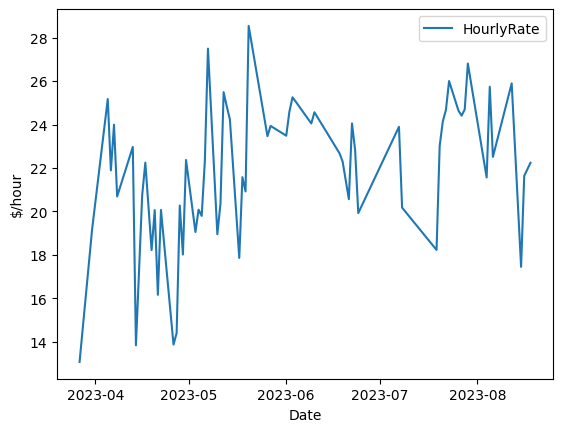

In [35]:
#https://builtin.com/data-science/time-series-python#

plt.ylabel('$/hour')
sns.lineplot(plotDF)
plt.show()

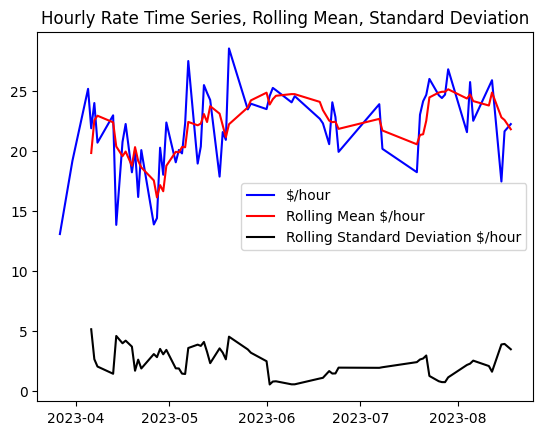

In [36]:
rolling_mean = plotDF.rolling(4).mean()
rolling_std = plotDF.rolling(4).std()

plt.plot(plotDF, color="blue",label="$/hour")
plt.plot(rolling_mean, color="red", label="Rolling Mean $/hour")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation $/hour")
plt.title("Hourly Rate Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()

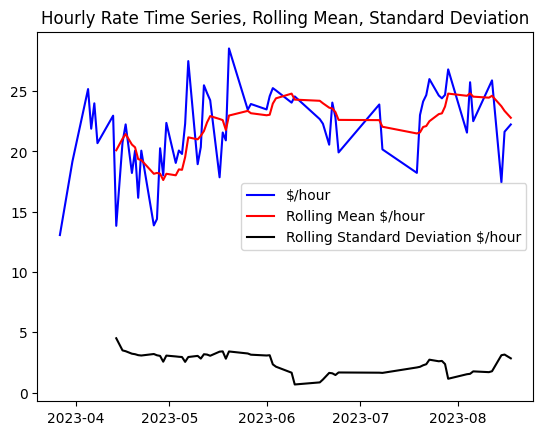

In [37]:
rolling_mean = plotDF.rolling(8).mean()
rolling_std = plotDF.rolling(8).std()

plt.plot(plotDF, color="blue",label="$/hour")
plt.plot(rolling_mean, color="red", label="Rolling Mean $/hour")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation $/hour")
plt.title("Hourly Rate Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.show()


In [38]:
#plt.close() 
from statsmodels.tsa.stattools import adfuller


In [39]:
adft = adfuller(plotDF,autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -1.650121              Test Statistics
1   0.456977                      p-value
2   4.000000             No. of lags used
3  61.000000  Number of observations used
4  -3.542413          critical value (1%)
5  -2.910236          critical value (5%)
6  -2.592745         critical value (10%)


In [40]:
autocorrelation_lag1 = plotDF['HourlyRate'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = plotDF['HourlyRate'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = plotDF['HourlyRate'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = plotDF['HourlyRate'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.33210394353591033
Three Month Lag:  0.2630936837097073
Six Month Lag:  0.14726675707942694
Nine Month Lag:  0.10954827311004908


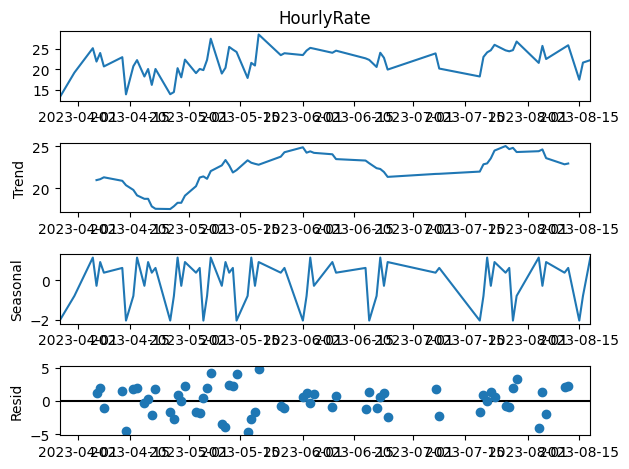

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(plotDF['HourlyRate'],model='additive', period=7)
decompose.plot()
plt.show()

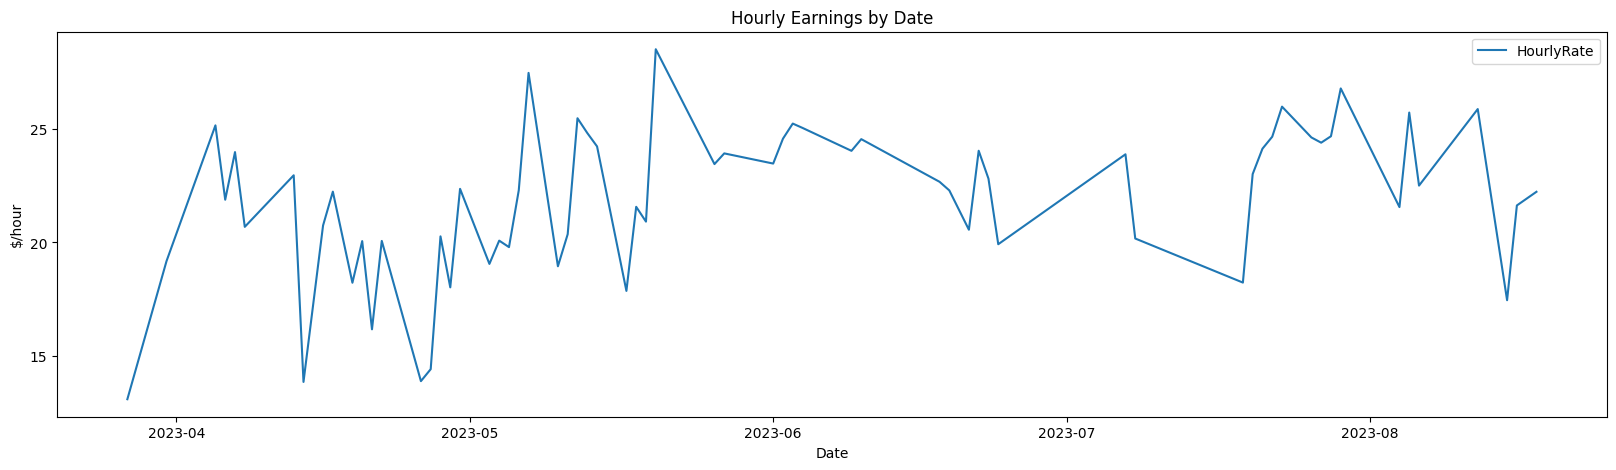

In [42]:
#plt.close() 
fig = plt.subplots(figsize=(20, 5))
plt.ylabel('$/hour')
sns.lineplot(plotDF).set(title='Hourly Earnings by Date')
sns.set_theme(style='white', font_scale=2)
#sns.reset_defaults()
plt.show()

In [43]:
#plt.clf()
#plt.close() 

In [44]:
#plotDF

In [45]:
plotDF = sheets_WeeksDF[["Start Date", "HourlyRate"]].copy()
plotDF.index = plotDF['Start Date']
del plotDF['Start Date']
plotDF

,HourlyRate
Start Date,
3/27,21.745421
4/3,25.107127
4/10,25.778872
4/17,22.785139
4/24,21.158854
5/1,23.397671
5/8,25.594702
5/15,25.286220
5/22,27.493701


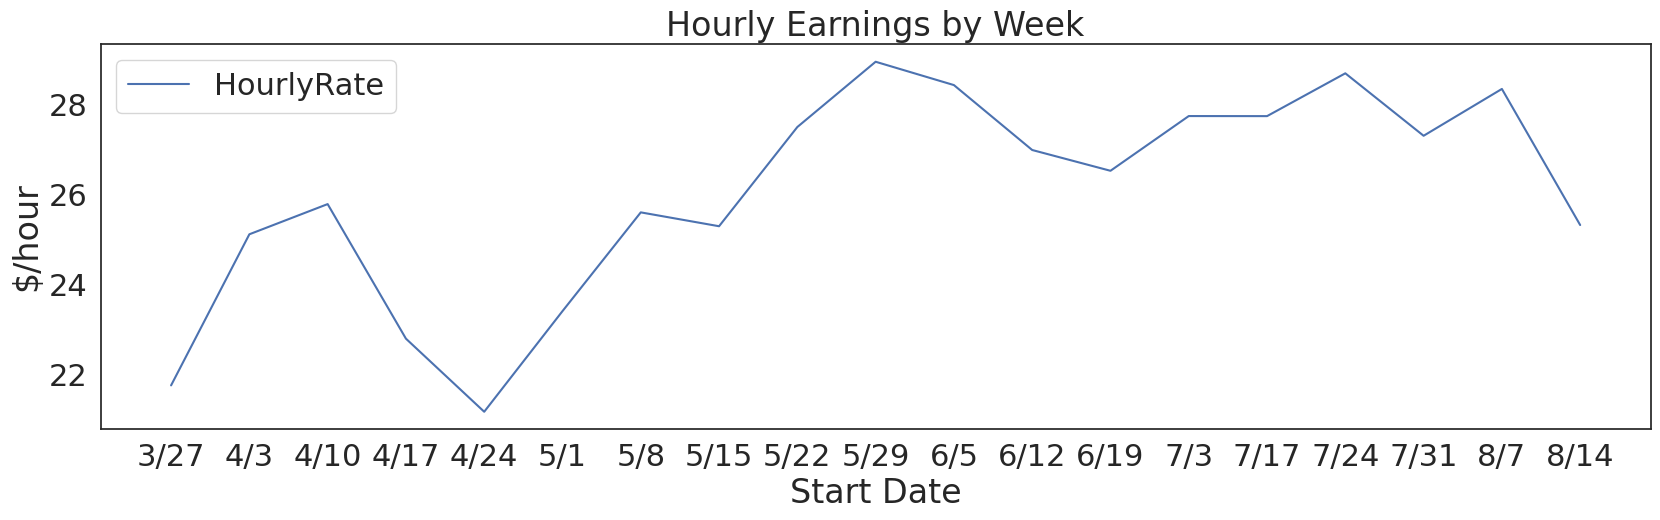

In [46]:
#plt.close() 
fig = plt.subplots(figsize=(20, 5))
plt.ylabel('$/hour')
sns.lineplot(plotDF).set(title='Hourly Earnings by Week')
sns.set_theme(style='white', font_scale=2)
#sns.reset_defaults()
plt.show()

In [47]:
DayOfWeekDF



,Sum Dash,Avg Daily Total,Sum Total,Sum Tip,Sum Deliveries,$/hr,Avg Delivery Tip,Avg Delivery Total
Day of Week,,,,,,,,
Friday,147.44,184.307222,3317.53,1512.28,346,22.50,4.370751,9.588237
Monday,17.85,125.823333,377.47,158.97,41,21.15,3.877317,9.206585
Saturday,116.18,178.880000,2683.20,1179.95,279,23.10,4.229211,9.617204
Sunday,49.58,147.347500,1178.78,545.53,122,23.78,4.471557,9.662131
Thursday,72.83,140.773636,1548.51,656.01,176,21.26,3.727330,8.798352
Tuesday,1.82,31.750000,31.75,14.00,3,17.45,4.666667,10.583333
Wednesday,72.49,135.787000,1357.87,549.87,155,18.73,3.547548,8.760452


In [48]:
plotDF = DayOfWeekDF[["$/hr", "Avg Delivery Tip", "Avg Delivery Total"]].copy()
plotDF = plotDF.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plotDF = plotDF.rename(columns={"$/hr": "Hourly Pay", 
                                "Avg Delivery Tip": "Average Tip", 
                                "Avg Delivery Total": "Average Delivery Total"})

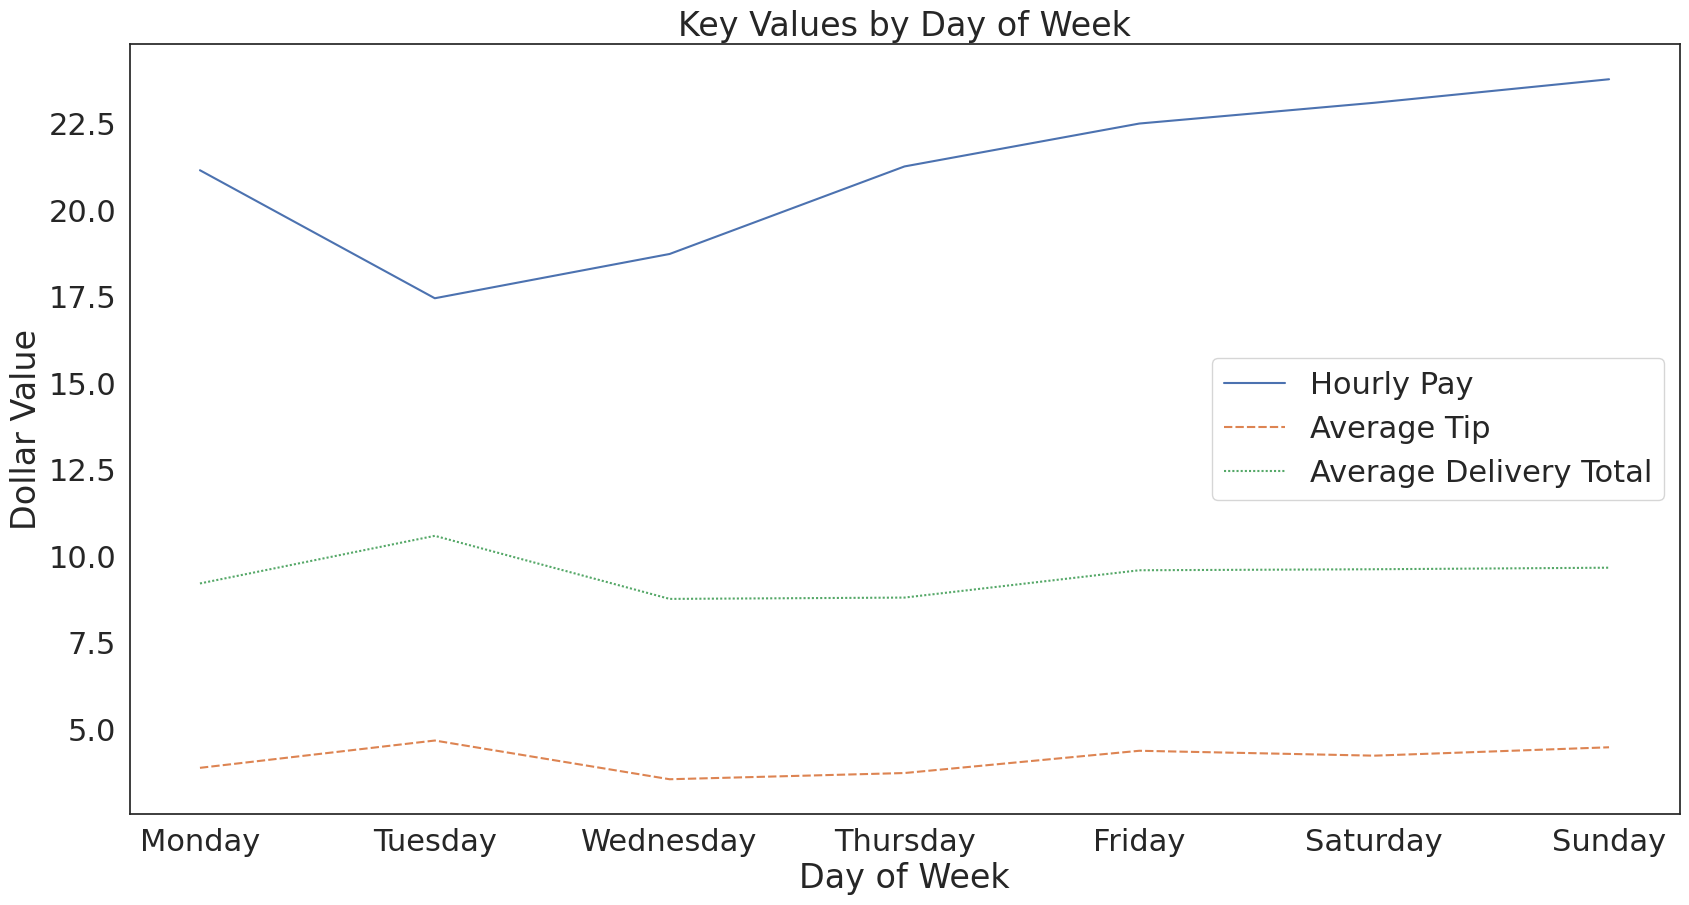

In [49]:
#plt.close() 

fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Dollar Value')
sns.lineplot(plotDF).set(title='Key Values by Day of Week')
plt.show()

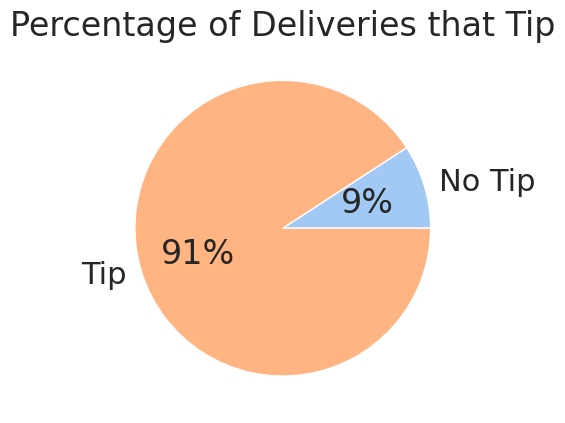

In [50]:
data0 = [numUntipped, numTipped]
labels0 = ['No Tip', 'Tip']
colors = sns.color_palette('pastel')[0:5]
plt.pie(data0, labels = labels0, colors = colors, autopct='%.0f%%')
plt.title('Percentage of Deliveries that Tip')
plt.show()

In [51]:
tempDF = restaurantsDF.sort_values(by=["Sum Total"], ascending=False).copy()
tempDF = tempDF.head()
tempDF = tempDF[["Sum Total"]]
overallTotal = sheets_WeeksDF.iloc[-1]["Total"]
leaderTotal = tempDF[["Sum Total"]].sum()
noLeaderTotal = overallTotal - leaderTotal
#tempDF.loc[len(tempDF.index)] = ["Others", noLeaderTotal]
s = noLeaderTotal
s.name = "All Others"
tempDF = tempDF.append(s)
tempDF

/tmp/ipykernel_5649/913864327.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tempDF = tempDF.append(s)


,Sum Total
Restaurant Name,
Chick-fil-A,1200.14
McDonald's,576.17
Taco Bell,574.12
Dave's Hot Chicken,512.00
Chipotle,447.67
All Others,8946.81


In [52]:
overallContribution = []
for index, row in tempDF.iterrows():
    x = round(row["Sum Total"] / overallTotal, 4)*100
    x = '%.2f' % x
    x = str(x) + '%'
    overallContribution.append(x)
overallContribution

['9.79%', '4.70%', '4.68%', '4.18%', '3.65%', '72.99%']

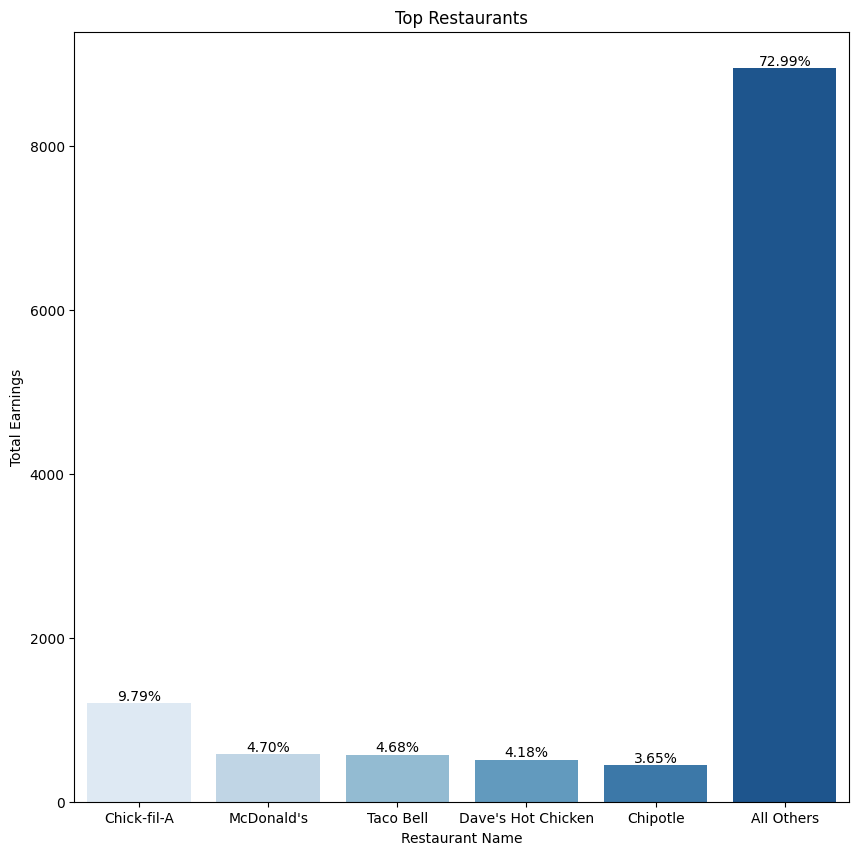

In [53]:
sns.reset_defaults()

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x = tempDF.index,
            y = 'Sum Total',
            data = tempDF,
            palette = "Blues").set(ylabel="Total Earnings", title="Top Restaurants")
#for i in ax.containers:
#    ax.bar_label(i,) 
# Show the plot
#ax.bar_label(ax.containers[0])
for bars in ax.containers:
        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

In [54]:
tempDF = restaurantsDF.sort_values(by=["Deliveries"], ascending=False).copy()
tempDF = tempDF.head()
tempDF = tempDF[["Deliveries"]]
overallTotal = sheets_WeeksDF.iloc[-1]["Deliveries"]
leaderTotal = tempDF[["Deliveries"]].sum()
noLeaderTotal = overallTotal - leaderTotal
#tempDF.loc[len(tempDF.index)] = ["Others", noLeaderTotal]
s = noLeaderTotal
s.name = "All Others"
tempDF = tempDF.append(s)
tempDF

/tmp/ipykernel_5649/920349414.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tempDF = tempDF.append(s)


,Deliveries
Restaurant Name,
Chick-fil-A,128
McDonald's,73
Taco Bell,66
Dave's Hot Chicken,54
Chipotle,54
All Others,747


In [55]:
overallContribution = []
for index, row in tempDF.iterrows():
    x = round(row["Deliveries"] / overallTotal, 4)*100
    x = '%.2f' % x
    x = str(x) + '%'
    overallContribution.append(x)
overallContribution

['11.41%', '6.51%', '5.88%', '4.81%', '4.81%', '66.58%']

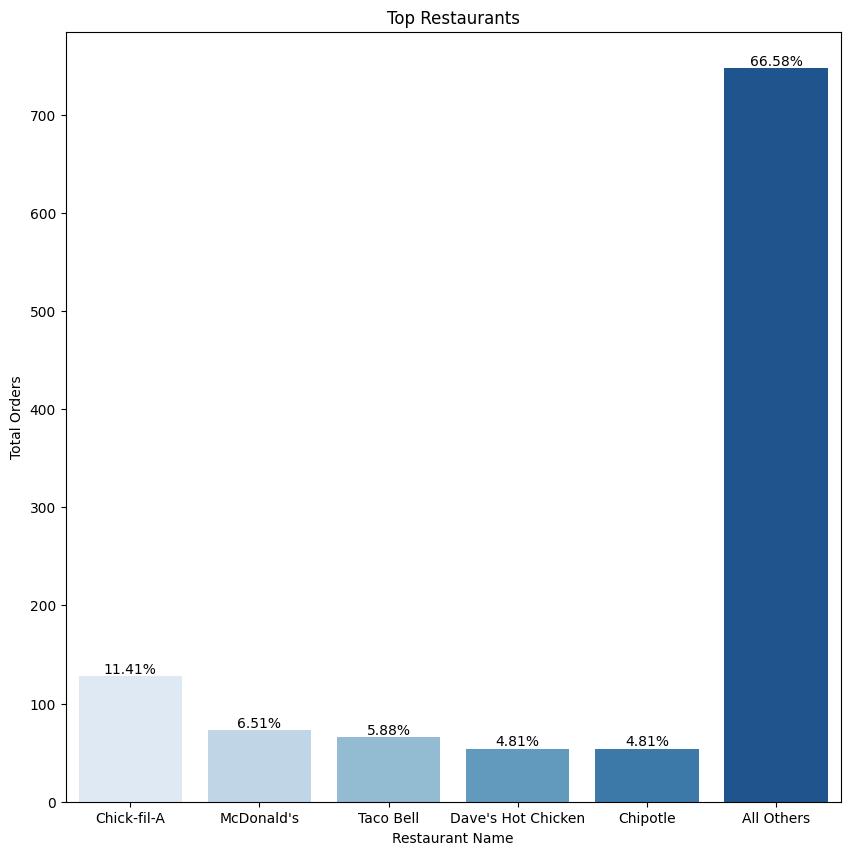

In [56]:
sns.reset_defaults()

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x = tempDF.index,
            y = 'Deliveries',
            data = tempDF,
            palette = "Blues").set(ylabel="Total Orders", title="Top Restaurants")
for bars in ax.containers:
        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

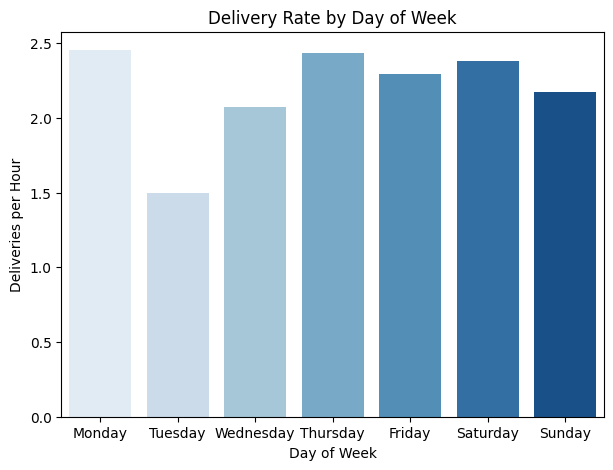

In [57]:
HourlyDelRateDF = sheets_result.groupby(["Date", "Day of Week", "Start Hour"]).agg({"Start Hour": 'size'})
HourlyDelRateDF2 = HourlyDelRateDF.groupby(["Day of Week"]).agg({"Start Hour": "mean"})
HourlyDelRateDF2 = HourlyDelRateDF2.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x = HourlyDelRateDF2.index,
            y = 'Start Hour',
            data = HourlyDelRateDF2,
            palette = "Blues").set(ylabel="Deliveries per Hour", title="Delivery Rate by Day of Week")
#for bars in ax.containers:
#        ax.bar_label(bars, labels=overallContribution)
plt.show()
plt.close()

In [58]:
#sheets_DaysDF.columns
tempDF = sheets_DaysDF.copy()
#newList = []
#tempDF.dtypes
#tempDF.iloc[0]["Date"].month

tempDF["Month"] = tempDF["Date"].dt.month
#tempDF.head()
tempDF = tempDF.groupby(["Month"]).agg({"Total": [np.mean, np.sum],
                                        "Tip": [np.mean, np.sum],
                                       "Active": [np.mean, np.sum],
                                       "Dash": [np.mean, np.sum],
                                       "Deliveries": [np.mean, np.sum],
                                       "HourlyRate": [np.mean],
                                       "ActiveMileage": [np.mean, np.sum],
                                       # "Total Mileage": [np.mean, np.sum],
                                       "Est Adj": [np.mean, np.sum]})
tempDF

#We need to convert - to 0 from Total Mileage values

Total                 Tip             Active              Dash  \
             mean      sum       mean      sum      mean     sum      mean   
Month                                                                        
3       98.250000   196.50  44.000000    88.00  3.345000    6.69  5.475000   
4      122.497647  2082.46  51.468235   874.96  4.121765   70.07  6.275294   
5      207.975000  3327.60  90.100000  1441.60  6.380000  102.08  9.425625   
6      197.030000  2364.36  89.259167  1071.11  6.347500   76.17  8.584167   
7      144.295455  1587.25  67.272727   740.00  4.397273   48.37  6.042727   
8      117.117500   936.94  50.117500   400.94  3.693750   29.55  5.033750   

              Deliveries      HourlyRate ActiveMileage           Est Adj  \
          sum       mean  sum       mean          mean    sum       mean   
Month                                                                      
3       10.95  11.000000   22  16.119805           NaN    0.0        NaN   
4      106.68  13.823529  235  19.703374           NaN    0.0        NaN   
5      150.81  22.125000  354  22.430972     78.700000  157.4  28.858000   
6      103.01  20.750000  249  23.278021     77.375000  928.5  32.791667   
7       66.47  14.909091  164  23.698740     56.009091  616.1  21.171273   
8       40.27  12.250000   98  22.794916     48.925000  391.4  16.122000   

                
           sum  
Month           
3        0.000  
4        0.000  
5       57.716  
6      393.500  
7      232.884  
8      128.976

In [64]:
#So we have average daily total, monthly total, 
#average daily tip, monthly total tip
#average active time, total active time
#average shift time, total shift time
#average daily deliveries, total deliveries
#avg monthly hourly rate
#avg and total active mileage
#avg and total est adj


#We want to normalize some of this, div by time or by delivery count

#HourlyRate is fine
#Delivery Total average is Total.sum/Deliveries.sum
#Tip Total avg is Tip.sum/Deliveries.sum
#Deliveries/Hour is Deliveries.sum/Dash.sum

#tempDF.iloc[0]["Total"]["mean"]
tempDF1 = tempDF.copy()
tempDF1["Average Delivery Total"] = tempDF["Total"]["sum"] / tempDF["Deliveries"]["sum"]
tempDF1["Average Delivery Tip"] = tempDF["Tip"]["sum"] / tempDF["Deliveries"]["sum"]
tempDF1["Deliveries per Hour"] = tempDF["Deliveries"]["sum"] / tempDF["Dash"]["sum"]
#Not sure how to select a multindex, can't do [["hourlyr"]]
#tempDF1[tempDF1.columns[10]] THIS IS SELECTS THE HOURLY RATE COLUMN, DO WE JUST ADD A NEW COLUMN WITH THOSE VALUES?
#We do for now
tempDF1["Hourly Rate"] = tempDF1[tempDF1.columns[10]]


tempDF1 = tempDF1[["Average Delivery Total", "Average Delivery Tip", "Deliveries per Hour", "Hourly Rate"]]
#tempDF1.dtypes

#This is lazy, should either get dt.month name somehow, check datetime options
#or func to convert num to string, dont hardcode
#tempDF1 = tempDF1.reindex(["March", "April", "May", "June", "July", "August"])
new_index = ["March", "April", "May", "June", "July", "August"]
tempDF1 = tempDF1.set_index(pd.Series(new_index))
#THIS DOESN'T WORK 

tempDF1

,Average Delivery Total,Average Delivery Tip,Deliveries per Hour,Hourly Rate
,,,,
March,8.931818,4.000000,2.009132,16.119805
April,8.861532,3.723234,2.202850,19.703374
May,9.400000,4.072316,2.347324,22.430972
June,9.495422,4.301647,2.417241,23.278021
July,9.678354,4.512195,2.467278,23.698740
August,9.560612,4.091224,2.433573,22.794916


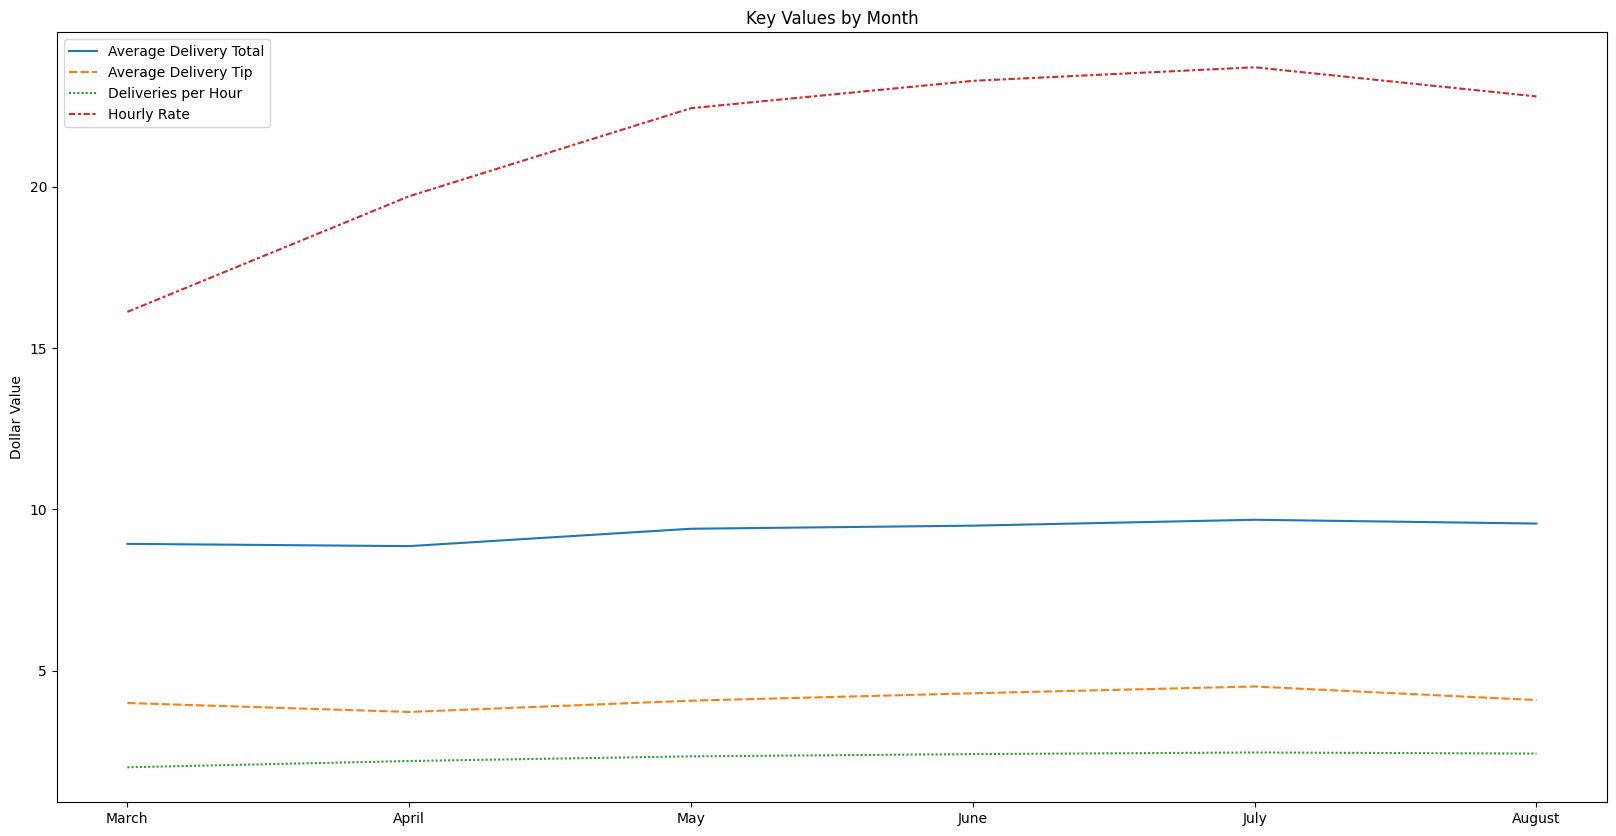

In [65]:
#tempDF1 = tempDF1.reindex(["March", "April", "May", "June", "July", "August"])

fig = plt.subplots(figsize=(20, 10))
plt.ylabel('Dollar Value')
sns.lineplot(tempDF1).set(title='Key Values by Month')
plt.show()

In [61]:
sns.reset_defaults()